# Uncertain Social Dilemma Plot

Uncomment the following tow cells (by deleting the leading `#`) if you are running this in Colab.

In [ ]:
# !git clone https://github.com/wbarfuss/POLD.git

In [ ]:
# cd POLD

In [1]:
# imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from environments.Env_UncertainSocialDilemma import UncertainSocialDilemma as ENV
from agents.deterministic import detQ

from utils import interact as ia

In [2]:
def setup_agents(AGENTS, alpha, beta, gamma, ENV, obs_noise):
    F1 = 1  # Fear
    G1 = 1  # Greed
    R1, P1 = 5, 0

    F2 = 1 # Feer
    G2 = -3.0 # Greed
    R2, P2 = 5, 0

    env = ENV(R1=R1, T1=R1+G1, S1=P1-F1, P1=P1,
              R2=R2, T2=R2+G2, S2=P2-F2, P2=P2,
              pC=0.5, obsnoise=obs_noise)
    T = env.TransitionTensor(); assert np.allclose(T.sum(-1), 1)
    O = env.ObservationTensor(); assert np.allclose(O.sum(-1), 1)
    R = env.RewardTensor()
    
    agents = AGENTS(T, R, O, alpha, beta, gamma)
    
    fid = f"{ENV.__name__}_{np.round(env.R1,3)}_{np.round(env.T1,3)}_"+\
        f"{np.round(env.S1,3)}_{np.round(env.P1,3)}_{np.round(env.R2,3)}_"+\
        f"{np.round(env.T2,3)}_{np.round(env.S2,3)}_{np.round(env.P2,3)}_"+\
        f"{np.round(env.pC,3)}_{env.noise}__"+\
        f"{AGENTS.__name__}_{np.round(alpha, 3)}_{np.round(beta,3)}_{gamma}"

    # make sure constraints are hold
    assert np.all(R[0,0,:,:,0].T == R[1,0,:,:,0])
    assert np.all(R[0,1,:,:,0].T == R[1,1,:,:,0])
    assert np.all(R[0,0,:,:,1] == R[0,0,:,:,1])
    assert np.all(R[0,1,:,:,1] == R[0,1,:,:,1])
    
    return agents, fid

def compute_data(agents, SampSize):
    Xs = [agents.random_behavior() for _ in range(SampSize)]
    Xtrajs, Rtrajs, fprs = [], [], []
    for i in range(len(Xs)):
        print(i)
        X = Xs[i]
        Xtraj, Rtraj, fpr = ia.compute_detXtraj(agents, X, EpsMin=1e-5,
                                                Tmax=10000)
        Xtrajs.append(Xtraj); Rtrajs.append(Rtraj), fprs.append(fpr)

    return dict(X=Xtrajs, R=Rtrajs, fp=fprs)

def get_data(agents, agentid, SampSize, datfolder=None):
    
    try:
        fn = agentid + f"__{SampSize}.npz"
        if datfolder is not None:
            fn = os.path.expanduser(datfolder) + fn
        dat = np.load(fn, allow_pickle=True)
        ddic = dict(zip((k for k in dat), (dat[k] for k in dat)))
        print("Loading ", fn)
    
    except:
        print("Computing ", fn)
        ddic = compute_data(agents, SampSize)
        if datfolder is not None:
            np.savez_compressed(fn, **ddic)
            
    return ddic

def get_bifuraction_data(AGENTS, alpha, beta, gamma, ENV, SampSize=100, 
                         HeterogeneousNoise=False, datfolder=None):
    
    fn = f'data/{ENV.__name__}_{AGENTS.__name__}_{alpha}_{beta}_{gamma}' +\
        f'_SaSi{SampSize}_Het{HeterogeneousNoise}.pkl'
    
    try: 
        df = pd.read_pickle(fn)
        print("LOADING", fn)
    except:

        if HeterogeneousNoise:
            noiselevels = np.unique(np.concatenate(
                [np.arange(0, 0.51, 0.01),
                 np.arange(0.2, 0.3, 0.002),
                 np.arange(0.22, 0.28, 0.001)]))
        else:
            noiselevels = np.unique(np.concatenate([
                np.arange(0, 0.51, 0.01),
                np.arange(0.28, 0.34, 0.002)]))

        print(f'== Bifurcation with {len(noiselevels)} noiselevels! ==')                                            
        
        df = pd.DataFrame(index=noiselevels, columns=['Rconv', 'Lconv'])
        
        for nl in noiselevels:
            n = [0, nl] if HeterogeneousNoise else [nl, nl]
            agents, fid = setup_agents(AGENTS, alpha, beta, gamma, ENV, obs_noise=n)
            ddic = get_data(agents, fid, SampSize, datfolder)
            Rconv = np.array([r[-1, :] for r in ddic["R"]])
            Lconv = np.array([len(r) for r in ddic["R"]])
            
            df.loc[nl,'Rconv'] = Rconv
            df.loc[nl,'Lconv'] = Lconv

        df.to_pickle(fn)

    return df

def plot_bifucation(AGENTS, alpha, beta, gamma, ENV, SampSize=100, axes=None,
                    HeterogeneousNoise=False, datfolder=None):
    if axes is None:
        _, axes = plt.subplots(2, 1, figsize=(7, 7))
        
    # Parameters
    Rrange=(-1, 6.)
    Rbins=50
    
    Lrange=(0, 800)
    Lbins = Rbins
    
    df = get_bifuraction_data(detQ, alpha, beta, gamma, ENV,
                              SampSize, HeterogeneousNoise,
                              datfolder=datfolder);
    
    noiselevels = np.array(df.index)
    hists1, hists2, rconvs, histL, lconvs = [], [], [], [], []
    for nl in noiselevels:
        n = [0, nl] if HeterogeneousNoise else [nl, nl]
        Rconv = df.loc[nl, 'Rconv']
        Lconv = df.loc[nl, 'Lconv']

        hists1.append(np.histogram(Rconv[:, 0], range=Rrange, bins=Rbins))
        hists2.append(np.histogram(Rconv[:, 1], range=Rrange, bins=Rbins))
        
        histL.append(np.histogram(Lconv, range=Lrange, bins=Lbins))
        rconvs.append(Rconv); lconvs.append(Lconv)
    

    # adjusting the noiselevels for the xaxis
    nls = np.array(noiselevels)
    dnl = np.mean(nls[1:] - nls[:-1]) / 2
    xnls = list(nls-dnl) + [nls[-1]+dnl]

    # the plots
    axes[0].pcolormesh(xnls, hists1[0][1], np.array([h[0] for h in hists1]).T,
                  cmap="Reds",alpha=0.5, vmin=1)
    axes[0].pcolormesh(xnls, hists1[0][1], np.array([h[0] for h in hists2]).T,
                  cmap="Blues",alpha=0.48, vmin=1)

    axes[1].pcolormesh(xnls, histL[0][1], np.array([h[0] for h in histL]).T,
                  cmap="viridis", alpha=1.0, vmin=0, vmax=5)


    return xnls, hists1, hists2, np.array(rconvs), np.array(lconvs)


## Plot

LOADING data/UncertainSocialDilemma_detQ_0.01_100.0_0.5_SaSi100_HetFalse.pkl
LOADING data/UncertainSocialDilemma_detQ_0.01_100.0_0.5_SaSi100_HetTrue.pkl


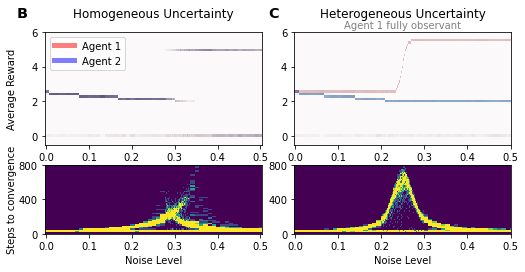

In [3]:
datfolder = None # for storage to speed up the plotting if you compute data yourself

SaSi = 100  # Sample Size
gamma = 0.5
beta = 50 / (1-gamma)
alpha = 0.01 


fsf = 0.6
fig = plt.figure(figsize=(fsf*12, fsf*6.))

gs = fig.add_gridspec(5, 2, wspace=0.15, hspace=0.8, left=0.08, right=0.98,
                      top=0.90, bottom=0.12)

axR1 = fig.add_subplot(gs[0:3, 0])
axL1 = fig.add_subplot(gs[3:, 0])
axR2 = fig.add_subplot(gs[0:3, 1])
axL2 = fig.add_subplot(gs[3:, 1])

axR1.set_ylim(-0.5, 6); axR2.set_ylim(-0.5, 6)
axL1.set_xlabel('Noise Level'); axL2.set_xlabel('Noise Level')
axL1.set_yticks([0, 400, 800]); axL2.set_yticks([0, 400, 800])

axR1.annotate(f"B", xy=(-0.08, 1.1), xycoords="axes fraction", color="k",
              ha="right", va="bottom", fontsize='x-large', weight='bold')
axR2.annotate(f"C", xy=(-0.07, 1.1), xycoords="axes fraction", color="k",
              ha="right", va="bottom", fontsize='x-large', weight='bold')

axR1.annotate("Homogeneous Uncertainty", xy=(0.5, 1.1), fontsize='large',
               xycoords="axes fraction", ha='center', va='bottom')
axR2.annotate("Heterogeneous Uncertainty", xy=(0.5, 1.1), fontsize='large',
               xycoords="axes fraction", ha='center', va='bottom')
axR2.annotate("Agent 1 fully observant", xy=(0.5, 1.01), fontsize='medium',
               xycoords="axes fraction", ha='center', va='bottom', color='gray')

axR1.annotate("Average Reward", xy=(-0.15, 0.5), fontsize='medium', rotation=90,
               xycoords="axes fraction", ha='center', va='center')
axL1.annotate("Steps to convergence", xy=(-0.15, 0.5), fontsize='medium', rotation=90,
               xycoords="axes fraction", ha='center', va='center')

ledli = [Line2D([0],[0], color=c, alpha=0.5, lw=5) for c in ["red", "blue"]]
ledla = [f"Agent {i}" for i in [1, 2]]
axR1.legend(ledli, ledla, loc="upper left", #  bbox_to_anchor=(1.0, 0.8), 
            ncol=1)

plot_bifucation(detQ, alpha, beta, gamma, ENV,
                SampSize=SaSi, axes=[axR1, axL1],
                HeterogeneousNoise=False,
                datfolder=datfolder);

plot_bifucation(detQ, alpha, beta, gamma, ENV,
                SampSize=SaSi, axes=[axR2, axL2],
                HeterogeneousNoise=True,
                datfolder=datfolder);

plt.savefig("figs/fig_UncertainDilemma.png", dpi=300, facecolor='w')